In [298]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D, MaxPooling2D, UpSampling2D, Reshape, Dropout
from keras.layers.convolutional import Conv1D, Conv2D
from keras.optimizers import SGD, Adam
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile
from keras.utils import plot_model

In [299]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Load the audio data

In [300]:
multitracks = mdb.load_multitracks([
    "Phoenix_ColliersDaughter", 
    "Phoenix_BrokenPledgeChicagoReel", 
    "Phoenix_ElzicsFarewell", 
    "Phoenix_LarkOnTheStrandDrummondCastle",
    "Phoenix_ScotchMorris",
    "Phoenix_SeanCaughlinsTheScartaglen"
])

In [301]:
mix_audio = None
instrument_audio = None

for mix in multitracks:
    sample_rate, song = wavfile.read(mix.mix_path)
    
    if mix_audio is None:
        mix_audio = song
    
    else:
        mix_audio = np.concatenate((mix_audio, song))
    
    #
    
    instruments = mdb.get_files_for_instrument("violin", [mix])

    instrument = next(instruments)
    
    sample_rate, track = wavfile.read(instrument)
    
    if instrument_audio is None:
        instrument_audio = track
    
    else:
        instrument_audio = np.concatenate((instrument_audio, track))
    
mix_audio = mix_audio.mean(1)
instrument_audio = instrument_audio.mean(1)

In [302]:
samples_per_period = 256
overlap = int(samples_per_period/2)

# Process the Mix

In [303]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

In [304]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))
#plt.title("STFT of the Mix")
#plt.ylabel("Frequency (Hz)")
#plt.xlabel("Time (s)")

# Process the Target Instrument

In [305]:
_, _, s_instrument = signal.stft(instrument_audio, fs=sample_rate, nfft=samples_per_period, 
                                               noverlap=overlap, nperseg=samples_per_period)

s_instrument = s_instrument[:-1,:]

s_instrument += 1e-9

In [306]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_instrument)))
#plt.title("STFT of the instrument Track")
#plt.xlabel("Time (s)")
#plt.ylabel("Frequency (Hz)")

# Prepare the training data

In [307]:
num_test  = int((sample_rate * 120)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

374742 20671


In [308]:
mix_train = s_mix.T[:num_train,np.newaxis,:]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=1)
mix_train.shape

(374742, 2, 128)

In [309]:
instrument_train = s_instrument.T[:num_train,np.newaxis,:]
instrument_train = np.concatenate((instrument_train.real, instrument_train.imag), axis=1)
instrument_train.shape

(374742, 2, 128)

In [310]:
mix_test = s_mix.T[-num_test+1:,np.newaxis,:]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=1)
mix_test.shape

(20670, 2, 128)

In [311]:
instrument_test = s_instrument.T[-num_test+1:,np.newaxis,:]
instrument_test = np.concatenate((instrument_test.real, instrument_test.imag), axis=1)
instrument_test.shape

(20670, 2, 128)

In [366]:
model = Sequential()

model.add(Dense(128, input_shape=mix_train.shape[1:], kernel_initializer="glorot_uniform"))
#model.add(Dense(256, activation="sigmoid", kernel_initializer="glorot_uniform"))
#
#model.add(Dropout(0.4))
#
model.add(Conv1D(128, 4, padding="same", activation="relu"))
#model.add(Conv1D(128, 4, padding="same", activation="relu"))
#
#model.add(Dropout(0.4))
#
#model.add(Dense(512, activation="sigmoid", kernel_initializer="glorot_uniform"))
model.add(Dense(128, kernel_initializer="glorot_uniform"))
#
#model.add(Dropout(0.4))
#
#model.add(Conv1D(128, 4, padding="same"))
#model.add(Conv1D(128, 4, padding="same"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 2, 128)            16512     
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 2, 128)            65664     
_________________________________________________________________
dense_144 (Dense)            (None, 2, 128)            16512     
Total params: 98,688
Trainable params: 98,688
Non-trainable params: 0
_________________________________________________________________


In [358]:
plot_model(model, to_file='model.png')

In [359]:
adam = Adam(lr=1e-3, beta_1=0.8, beta_2=0.999, epsilon=1e-9, decay=0.0, amsgrad=False)

#sgd = SGD(lr=0.001, momentum=1.1, decay=1.1, nesterov=True)

model.compile(adam, loss='mean_squared_error', metrics=['accuracy'])

In [360]:
history = model.fit(mix_train, instrument_train, batch_size=10000, epochs=10000)

Epoch 1/10000
374742/374742 [==============================] - 7s 18us/step - loss: 2761.3812 - acc: 0.2464
Epoch 2/10000
374742/374742 [==============================] - 4s 12us/step - loss: 2468.9688 - acc: 0.2975
Epoch 3/10000
374742/374742 [==============================] - 4s 12us/step - loss: 2355.4905 - acc: 0.2981
Epoch 4/10000
374742/374742 [==============================] - 4s 12us/step - loss: 2308.4292 - acc: 0.2990
Epoch 5/10000
374742/374742 [==============================] - 4s 12us/step - loss: 2285.6024 - acc: 0.2994
Epoch 6/10000
374742/374742 [==============================] - 4s 12us/step - loss: 2271.7715 - acc: 0.2995
Epoch 7/10000
374742/374742 [==============================] - 4s 12us/step - loss: 2263.2053 - acc: 0.2995
Epoch 8/10000
210000/374742 [===============>..............] - ETA: 1s - loss: 2262.9632 - acc: 0.3003

KeyboardInterrupt: 

In [361]:
results = model.evaluate(mix_test, instrument_test)

print(model.metrics_names)
print(results)

20670/20670 [==============================] - 2s 106us/step
['loss', 'acc']
[2779.5585704618916, 0.3208514755785494]


# Results

In [362]:
prediction = model.predict(mix_test)
prediction.shape

(20670, 2, 128)

In [363]:
prediction = (prediction[:,0,:]+prediction[:,1,:] * 1j).T
prediction += 1e-9

In [364]:
target = s_instrument[:, -num_test:]

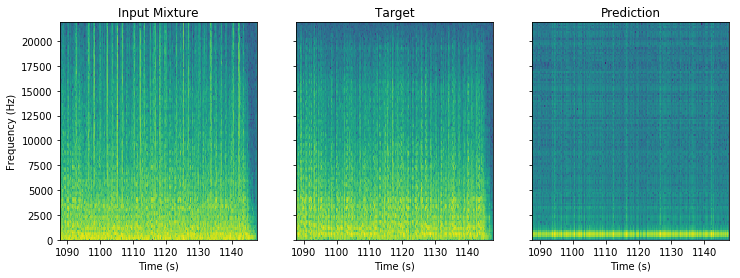

In [365]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Prediction")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Time (s)")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [249]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)
_, target_audio = signal.istft(target, fs=sample_rate)
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

wavfile.write("conv_1d_model_instrument_prediction.wav", sample_rate, predicted_audio.astype(np.int16))
wavfile.write("conv_1d_model_instrument_target.wav", sample_rate, target_audio.astype(np.int16))
wavfile.write("conv_1d_model_original.wav", sample_rate, mix_audio.astype(np.int16))